# Model with tracks

In [152]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras import metrics
import numpy as np

from matplotlib import pyplot as plt


In [117]:
 # Load back from the pickle file.
import pickle

songs_with_tracks = pickle.load( open( "./songs_with_tracks.p", "rb" ) )

In [118]:
tracks = []
[[tracks.append(track) for track in song if len(track) > 5] for song in songs_with_tracks];

In [119]:
len(tracks)

782

In [120]:
import fractions

In [121]:
duration_to_number = {}
number_to_duration  = {}

count=0
duration = 0
while duration <= 20:
    number_to_duration[count] = duration
    duration_to_number[duration] = count
    count+=1
    duration+=0.25

duration = 0
while duration <= 20:
    if not duration in duration_to_number:
        number_to_duration[count] = duration
        duration_to_number[duration] = count
        count+=1
    duration+=fractions.Fraction(1,3)

In [122]:
interval_to_number = {}
number_to_interval = {}

for i in range(0,100):
    interval_to_number[i] = i
    interval_to_number[-i] = 100 + i
    number_to_interval[i] = i
    number_to_interval[100+i] = -i

In [123]:
train_set = [ \
    [\
        [
         duration_to_number[round(element['relative_offset']*4)/4] if (round(element['relative_offset']*4)/4 in duration_to_number) else 1, 
         interval_to_number[element['interval']], 
         duration_to_number[element['duration']]
        ] \
    for element in track]\
for track in tracks]

In [124]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences)[i:end_ix, :], np.array(sequences)[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [125]:
X, y = [], []
for i in range(len(train_set)):
    X_temp, y_temp = split_sequences(train_set[i], 10)
      
    if (len(X_temp) > 0 and len(y_temp) > 0):
        X = X_temp if len(X)==0 else np.concatenate([X,X_temp])
        y = y_temp if len(y)==0 else np.concatenate([y,y_temp])
    



In [151]:
# Save into a pickle file.
import pickle

pickle.dump( tracks, open( "training_tracks_seqlength10.p", "wb" ) )

In [127]:
from keras.layers import Dense, Dropout, LSTM, Input
from keras import Model
from keras.metrics import SparseTopKCategoricalAccuracy

In [128]:
hid = 20
past_time_steps = 10
n_features = 3
future_time_steps = 1
inputs = Input(shape=(past_time_steps, n_features))
m = LSTM(hid, return_sequences=True)(inputs)
m = Dropout(0.5)(m)
m = LSTM(hid)(m)
m = Dropout(0.5)(m)

#outputA = Dense(future_time_steps, activation='linear')(m)
#outputB = Dense(future_time_steps, activation='linear')(m)
#outputC = Dense(future_time_steps, activation='linear')(m)

outputA = Dense(len(duration_to_number), activation='softmax')(m)
outputB = Dense(len(interval_to_number), activation='softmax')(m)
outputC = Dense(len(duration_to_number), activation='softmax')(m)

m = Model(inputs=[inputs], outputs=[outputA, outputB, outputC])
#m.compile(optimizer='adam', loss='mae')

m.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[SparseTopKCategoricalAccuracy(k=3, name='sparse_top_k_categorical_accuracy')])


m.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10, 3)        0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 10, 20)       1920        input_3[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 10, 20)       0           lstm_5[0][0]                     
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 20)           3280        dropout_5[0][0]                  
____________________________________________________________________________________________

In [129]:
# checkpoint
filepath="models_checkpoints/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks_list = [checkpoint, early_stopping]

In [130]:
BATCH_SIZE = 64
EPOCHS = 50

In [131]:
y1 = y[:,0]
y2 = y[:,1]
y3 = y[:,2]

In [132]:
history = m.fit(X, [y1,y2,y3], validation_split = 0.1,  batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks_list)

Train on 13507 samples, validate on 1501 samples
Epoch 1/50
13507/13507 [==============================] - 9s 662us/step - loss: 7.3266 - dense_7_loss: 2.1844 - dense_8_loss: 3.4552 - dense_9_loss: 1.6755 - dense_7_sparse_top_k_categorical_accuracy: 0.8293 - dense_8_sparse_top_k_categorical_accuracy: 0.4020 - dense_9_sparse_top_k_categorical_accuracy: 0.9245 - val_loss: 4.5242 - val_dense_7_loss: 1.1893 - val_dense_8_loss: 2.6813 - val_dense_9_loss: 0.6436 - val_dense_7_sparse_top_k_categorical_accuracy: 0.9294 - val_dense_8_sparse_top_k_categorical_accuracy: 0.4684 - val_dense_9_sparse_top_k_categorical_accuracy: 0.9880431 - dense_7_loss: 4.2417 - dense_8_loss: 4.9136 - dense_9_loss: 3.9878 - dense_7_spars - ETA: 0s - loss: 7.4269 - dense_7_loss: 2.2266 - dense_8_loss: 3.4791 - dense_9_loss: 1.7212 - dense_7_sparse_top_k_categorical_accuracy: 0.8250 - dense_8_sparse_top_k_categorical_accuracy: 0.3990 - dense_9_sparse_top_k_categorical_accuracy: 0.92 - ETA: 0s - loss: 7.4001 - dense_7_

In [98]:
from matplotlib import pyplot as plt

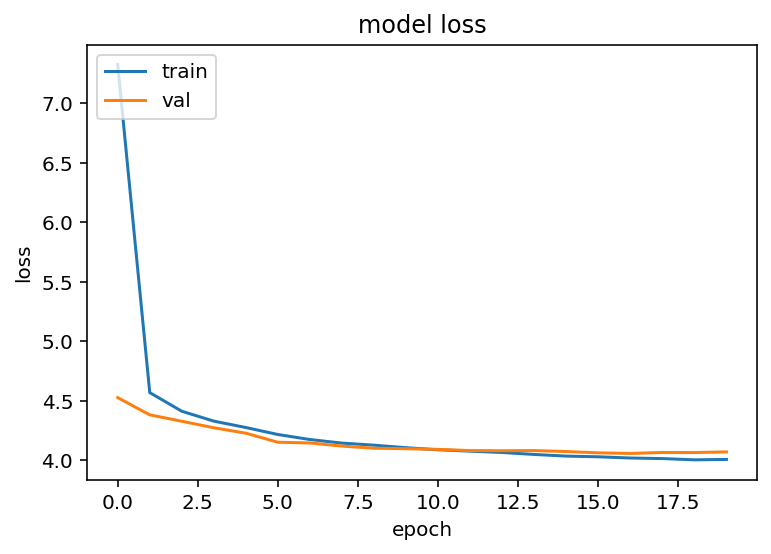

In [133]:
plt.plot(m.history.history['loss'])
plt.plot(m.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [134]:
from random import randint
def sample(preds):
    sorted_indexes = np.argsort(preds)[::-1]
    return sorted_indexes[randint(0,3)]

In [135]:
def sample_seq( seq, seq_length, model, number_to_note, output_seq_length ):
    if output_seq_length <= len(seq): raise Exception("output_seq_length must be higher than seq_length")
        
    output_seq = seq
    for i in range(output_seq_length - len(seq)):
        input_sequence = [seq[-seq_length:]]
        x = [pad_sequences(input_sequence, maxlen = seq_length, padding="pre")]
        prediction = model.predict(x)
        
        index1 = sample(prediction)
        
        index = sample(prediction[0])
        output_seq.append(index)
    #[number_to_note(number) for number in output_seq]
    return output_seq

In [136]:
from keras.preprocessing.sequence import pad_sequences

In [137]:
def pad( input_seq, desired_length, fill_value):
    if len(input_seq) >= desired_length:
        return input_seq
    else: 
        [input_seq.insert(0, fill_value) for i in range(0, desired_length - len(input_seq))]
        return input_seq

In [138]:
def sample_seq( input_seq, length_expected_by_model, model, output_seq_length, padding_fill_value ):
    if output_seq_length <= len(input_seq): raise Exception("output_seq_length must be higher than seq_length")
        
    output_seq = input_seq
    for i in range(output_seq_length - len(input_seq)):
        input_sequence = input_seq[-length_expected_by_model:]
        x = [pad(input_sequence, length_expected_by_model, padding_fill_value)]
        #print(x)
        prediction = model.predict(np.array(x))
        #print(prediction[0][0])
        
        index1 = sample(prediction[0][0])
        index2 = sample(prediction[1][0])
        index3 = sample(prediction[2][0])
        #index = sample(prediction[0])
        output_seq.append([index1, index2, index3])
    return output_seq

In [139]:
sample_seq([[1,1,1]], 10, m, 5, [0,0,0])

[[1, 1, 1], [3, 105, 2], [1, 2, 1], [2, 105, 81], [0, 102, 4]]

In [140]:
generated_vector = sample_seq([[1,1,1]], 10, m, 50, [0,0,0])

In [141]:
generated_vector

[[1, 1, 1],
 [1, 100, 4],
 [0, 100, 1],
 [2, 105, 2],
 [2, 105, 1],
 [0, 105, 4],
 [1, 2, 1],
 [3, 2, 2],
 [3, 100, 1],
 [3, 102, 1],
 [1, 105, 81],
 [2, 105, 1],
 [2, 105, 2],
 [1, 2, 4],
 [3, 105, 2],
 [3, 2, 1],
 [2, 105, 2],
 [1, 100, 4],
 [2, 2, 1],
 [0, 102, 4],
 [0, 100, 2],
 [0, 100, 81],
 [2, 100, 81],
 [0, 100, 2],
 [2, 105, 1],
 [3, 102, 2],
 [2, 100, 1],
 [1, 2, 1],
 [0, 102, 1],
 [0, 100, 4],
 [0, 102, 81],
 [0, 105, 1],
 [1, 100, 4],
 [2, 102, 4],
 [0, 2, 81],
 [2, 2, 4],
 [3, 105, 4],
 [3, 102, 81],
 [1, 105, 1],
 [2, 2, 81],
 [0, 102, 81],
 [2, 100, 1],
 [3, 105, 81],
 [1, 7, 1],
 [0, 102, 4],
 [0, 2, 4],
 [1, 102, 2],
 [0, 105, 4],
 [1, 102, 1],
 [1, 2, 2]]

In [142]:
generated_intervals = [{'relative_offset': number_to_duration[generated_item[0]], 'interval': number_to_interval[generated_item[1]], 'duration': number_to_duration[generated_item[2]]} for generated_item in generated_vector]

In [144]:
generated_intervals

[{'relative_offset': 0.25, 'interval': 1, 'duration': 0.25},
 {'relative_offset': 0.25, 'interval': 0, 'duration': 1.0},
 {'relative_offset': 0, 'interval': 0, 'duration': 0.25},
 {'relative_offset': 0.5, 'interval': -5, 'duration': 0.5},
 {'relative_offset': 0.5, 'interval': -5, 'duration': 0.25},
 {'relative_offset': 0, 'interval': -5, 'duration': 1.0},
 {'relative_offset': 0.25, 'interval': 2, 'duration': 0.25},
 {'relative_offset': 0.75, 'interval': 2, 'duration': 0.5},
 {'relative_offset': 0.75, 'interval': 0, 'duration': 0.25},
 {'relative_offset': 0.75, 'interval': -2, 'duration': 0.25},
 {'relative_offset': 0.25, 'interval': -5, 'duration': Fraction(1, 3)},
 {'relative_offset': 0.5, 'interval': -5, 'duration': 0.25},
 {'relative_offset': 0.5, 'interval': -5, 'duration': 0.5},
 {'relative_offset': 0.25, 'interval': 2, 'duration': 1.0},
 {'relative_offset': 0.75, 'interval': -5, 'duration': 0.5},
 {'relative_offset': 0.75, 'interval': 2, 'duration': 0.25},
 {'relative_offset': 0.

In [145]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch, stream, interval, duration

In [146]:
def from_array_of_intervals_to_pitches_with_time (root_pitch, intervals_with_time):
    elements = [{
            'absolute_offset': 0, 
            'pitch': root_pitch, 
            'duration': 1
        }]
    for interval in intervals_with_time:
        previousElement = elements[-1]
        resultElement = {
            'absolute_offset': float(previousElement['absolute_offset'] + interval['relative_offset']), 
            'pitch': float(previousElement['pitch'] + interval['interval']), 
            'duration': float(interval['duration']),
        }
        elements.append(resultElement)
    return elements

def from_pitches_with_time_to_midi (pitches_with_time, midi_path):
    print(pitches_with_time)
    streamResult = stream.Stream()
    for pitch_with_time in pitches_with_time:
        element = note.Note(pitch_with_time['pitch'])
        element._setOffset(pitch_with_time['absolute_offset'])
        d = duration.Duration()
        d.quarterLength = pitch_with_time['duration']
        element.duration = d
        streamResult.append(element)
            
    streamResult.write('midi', fp= midi_path)
    
def from_intervals_with_time_to_midi( root_pitch, intervals, midi_path):
    pitches_with_time = from_array_of_intervals_to_pitches_with_time(root_pitch, intervals)
    from_pitches_with_time_to_midi(pitches_with_time, midi_path)

In [147]:
from_array_of_intervals_to_pitches_with_time(100, generated_intervals)

[{'absolute_offset': 0, 'pitch': 100, 'duration': 1},
 {'absolute_offset': 0.25, 'pitch': 101.0, 'duration': 0.25},
 {'absolute_offset': 0.5, 'pitch': 101.0, 'duration': 1.0},
 {'absolute_offset': 0.5, 'pitch': 101.0, 'duration': 0.25},
 {'absolute_offset': 1.0, 'pitch': 96.0, 'duration': 0.5},
 {'absolute_offset': 1.5, 'pitch': 91.0, 'duration': 0.25},
 {'absolute_offset': 1.5, 'pitch': 86.0, 'duration': 1.0},
 {'absolute_offset': 1.75, 'pitch': 88.0, 'duration': 0.25},
 {'absolute_offset': 2.5, 'pitch': 90.0, 'duration': 0.5},
 {'absolute_offset': 3.25, 'pitch': 90.0, 'duration': 0.25},
 {'absolute_offset': 4.0, 'pitch': 88.0, 'duration': 0.25},
 {'absolute_offset': 4.25, 'pitch': 83.0, 'duration': 0.3333333333333333},
 {'absolute_offset': 4.75, 'pitch': 78.0, 'duration': 0.25},
 {'absolute_offset': 5.25, 'pitch': 73.0, 'duration': 0.5},
 {'absolute_offset': 5.5, 'pitch': 75.0, 'duration': 1.0},
 {'absolute_offset': 6.25, 'pitch': 70.0, 'duration': 0.5},
 {'absolute_offset': 7.0, 'pi

In [148]:
#model_interval.load_weights('models_checkpoints/weights-improvement-10-2.87.hdf5')

In [149]:
from datetime import datetime

In [150]:
from_intervals_with_time_to_midi(100, generated_intervals, datetime.now().strftime("%Y%m%d_%H%M%S")+'_generated_record_intervals_tuning_with_tracks.mid')

[{'absolute_offset': 0, 'pitch': 100, 'duration': 1}, {'absolute_offset': 0.25, 'pitch': 101.0, 'duration': 0.25}, {'absolute_offset': 0.5, 'pitch': 101.0, 'duration': 1.0}, {'absolute_offset': 0.5, 'pitch': 101.0, 'duration': 0.25}, {'absolute_offset': 1.0, 'pitch': 96.0, 'duration': 0.5}, {'absolute_offset': 1.5, 'pitch': 91.0, 'duration': 0.25}, {'absolute_offset': 1.5, 'pitch': 86.0, 'duration': 1.0}, {'absolute_offset': 1.75, 'pitch': 88.0, 'duration': 0.25}, {'absolute_offset': 2.5, 'pitch': 90.0, 'duration': 0.5}, {'absolute_offset': 3.25, 'pitch': 90.0, 'duration': 0.25}, {'absolute_offset': 4.0, 'pitch': 88.0, 'duration': 0.25}, {'absolute_offset': 4.25, 'pitch': 83.0, 'duration': 0.3333333333333333}, {'absolute_offset': 4.75, 'pitch': 78.0, 'duration': 0.25}, {'absolute_offset': 5.25, 'pitch': 73.0, 'duration': 0.5}, {'absolute_offset': 5.5, 'pitch': 75.0, 'duration': 1.0}, {'absolute_offset': 6.25, 'pitch': 70.0, 'duration': 0.5}, {'absolute_offset': 7.0, 'pitch': 72.0, 'dur